In [39]:
import pandas as pd
import numpy as np
import json
import re
from collections import defaultdict
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(precision = 4, suppress = True)
plt.style.use('seaborn-whitegrid')

In [93]:
eda = pd.read_csv('../WebScraping/edaru.csv')

In [111]:
ingredients = {}
for ings in eda.loc[:, 'ingredients'].values:
    for i in eval(ings):
        ingredients[eval(i)['id']] = eval(i)['name']

In [112]:
len(ingredients)

775

In [25]:
with open('ingredients.json', 'w') as f:
    json.dump(ingredients, f)

In [110]:
eda.head(4)

,img,title,link,stepbystep,cuisine,portions,time,ingredients,favourite,likes,dislikes,us,eu,ru,minutes
0,https://img05.rl0.ru/eda/c285x285i/s1.eda.ru/P...,Брауни (brownie),https://eda.ru/recepty/vypechka-deserty/brauni...,1,Американская кухня,6,40 минут,"['{""id"": 14797, ""name"": ""Темный шоколад"", ""amo...",25312,2996,247,1,0,0,40
1,https://img01.rl0.ru/eda/c285x285i/s2.eda.ru/P...,Цветаевский яблочный пирог,https://eda.ru/recepty/vypechka-deserty/cvetae...,1,Европейская кухня,4,0,"['{""id"": 13447, ""name"": ""Яблоко"", ""amount"": ""1...",15207,1960,190,0,1,0,0
2,https://img05.rl0.ru/eda/c285x285i/s1.eda.ru/P...,Классическая шарлотка,https://eda.ru/recepty/vypechka-deserty/klassi...,1,Русская кухня,12,35 минут,"['{""id"": 13410, ""name"": ""Сахар"", ""amount"": ""1 ...",18829,1948,223,0,0,1,35
3,https://img09.rl0.ru/eda/c285x285i/s2.eda.ru/P...,Тонкие блины на молоке,https://eda.ru/recepty/vypechka-deserty/tonkie...,1,NaN,4,40 минут,"['{""id"": 13458, ""name"": ""Пшеничная мука"", ""amo...",14250,1707,288,0,0,0,40


In [99]:
eda['us'] = np.where(eda.cuisine.str.contains('Американская', na=False), 1, 0) # na=False returns 0 when nan
eda.us = eda.us.astype('category')

In [100]:
eda['eu'] = np.where(eda.cuisine.str.contains('Европейская', na=False), 1, 0) # na=False returns 0 when nan
eda.us = eda.us.astype('category')
eda['ru'] = np.where(eda.cuisine.str.contains('Русская', na=False), 1, 0) # na=False returns 0 when nan
eda.us = eda.us.astype('category')

In [101]:
eda.stepbystep = eda.stepbystep.astype('category')

In [102]:
print(f'out of {eda.shape[0]} recipes, {eda.cuisine.isna().sum()} \
({round(100*eda.cuisine.isna().sum()/eda.shape[0], 1)}%) are missing cuisine')
print(f'american: {eda[eda.us == 1].shape[0]}\n\
european: {eda[eda.eu == 1].shape[0]}\n\
russian: {eda[eda.ru == 1].shape[0]}')
print(f'step by step: {eda[eda.stepbystep == 1].shape[0]}')
print(f'{eda.time.isna().sum()} missing time') # use average? median? 

out of 1769 recipes, 446 (25.2%) are missing cuisine
american: 141
european: 375
russian: 286
step by step: 85
164 missing time


In [103]:
eda.time = eda.time.fillna(0)

In [104]:
# substitute 0s for average
minutes = []
hour = re.compile('час')
mins = re.compile('минут')
for time in eda.loc[:, 'time'].values:
    if time == 0:
        minutes.append(0)
        
    else:
        
        # if end with hours
        if hour.search(time.split(' ')[-1]):
            t = int(time.split(' ')[-2])*60
            minutes.append(t)
            
        
        # if ends with minutes
        elif mins.search(time.split(' ')[-1]):
            t = int(time.split(' ')[-2])
        
            # check if contains hours
            try:
                t += int(time.split(' ')[-4])*60
                minutes.append(t)
            except IndexError:
                minutes.append(t)
                
eda['minutes'] = minutes

In [148]:
edacopy = eda.loc[:, ['portions', 'ingredients', 'minutes']]

In [149]:
edacopy.head()

,portions,ingredients,minutes
0,6,"['{""id"": 14797, ""name"": ""Темный шоколад"", ""amo...",40
1,4,"['{""id"": 13447, ""name"": ""Яблоко"", ""amount"": ""1...",0
2,12,"['{""id"": 13410, ""name"": ""Сахар"", ""amount"": ""1 ...",35
3,4,"['{""id"": 13458, ""name"": ""Пшеничная мука"", ""amo...",40
4,4,"['{""id"": 13418, ""name"": ""Яйцо куриное"", ""amoun...",60


In [132]:
s = set()
for ings in edacopy.loc[:, 'ingredients'].values:
    for i in eval(ings):
        s.add(' '.join(eval(i)['amount'].split(' ')[1:]))
s

{'',
 'банка',
 'банки',
 'веточки',
 'вкусу',
 'г',
 'головка',
 'головки',
 'головок',
 'зубчик',
 'зубчика',
 'зубчиков',
 'кг',
 'кончике ножа',
 'куска',
 'кусков',
 'кусок',
 'л',
 'мл',
 'пучка',
 'пучок',
 'стакан',
 'стакана',
 'стаканов',
 'стебель',
 'стеблей',
 'стебля',
 'столовая ложка',
 'столовой ложки',
 'столовые ложки',
 'столовых ложек',
 'чайная ложка',
 'чайной ложки',
 'чайные ложки',
 'чайных ложек',
 'штук',
 'штука',
 'штуки'}

In [150]:
for i in sorted(list(ingredients.keys())):
    edacopy[str(i)] = 0

In [151]:
edacopy.shape

(1769, 778)

## Веса продуктов

яйцо = 50г

яблоко = 175г

банан = 200г

стакан сахара/муки = 160г

столовая ложка = 20г

чайная ложка = 5г

банка сметаны = 200г

кусок = 200г

кусок шоколада = 50г

головка лука = 85г

головка чеснока = 45г

зубчик = 10г

стебель = 60г

по вкусу = 0г

на кончике ножа = 0г

щепотка = 0г

мл = г

л = 1000г

In [152]:
# for each row extract ingredients
for n in range(edacopy.shape[0]):
    for i in eval(edacopy.loc[n, 'ingredients']):

        # if grams or ml
        if eval(i)['amount'].split(' ')[-1] == 'г' or eval(i)['amount'].split(' ')[-1] == 'мл':
            try:
                value = int(eval(i)['amount'].split(' ')[-2])
            # has a comma
            except ValueError:
                try:
                    value = int(''.join(eval(i)['amount'].split(' ')[-2].split(',')))
                # a stupid fraction of a gram
                except ValueError:
                    value = 0

        # if kg or l
        elif eval(i)['amount'].split(' ')[-1] == 'кг' or eval(i)['amount'].split(' ')[-1] == 'л':
            try:
                value = int(eval(i)['amount'].split(' ')[-2])*1000
            # has a comma
            except ValueError:
                try:
                    value = float('.'.join(eval(i)['amount'].split(' ')[-2].split(',')))*1000
                # a stupid fraction of a gram
                except ValueError:
                    value = 500

        # if an egg
        elif re.compile('йцо').search(eval(i)['name']) or re.compile('желт').search(eval(i)['name'])\
                or re.compile('белок').search(eval(i)['name']):
            value =  int(eval(i)['amount'][0])*50

        # if a banana
        elif re.compile('анан').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*200
            # a stupid fraction 
            except ValueError:
                value = 100

        # if an apple:
        elif re.compile('блоко').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*175
            # a stupid fraction
            except ValueError:
                value =  100

        # if a glass
        elif re.compile('стакан').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*160
            # a stupid fraction
            except ValueError:
                value = 100

        # table spoon
        elif re.compile('стол').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*20
            # a stupid fraction
            except ValueError:
                value = 10

        # tea spoon
        elif re.compile('чайн').search(eval(i)['amount']):
            try:
                 value = int(eval(i)['amount'][0])*5
            # a stupid fraction
            except ValueError:
                value = 3

        # can
        elif re.compile('банк').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*200
            # has a comma
            except ValueError:
                try:
                    value = float('.'.join(eval(i)['amount'].split(' ')[0].split(',')))*200
                # a stupid fraction
                except ValueError:
                     value = 100

        # по вкусу
        elif re.compile('вкус').search(eval(i)['amount']) or re.compile('нож').search(eval(i)['amount'])\
                or re.compile('щепотка').search(eval(i)['amount']):
            value = 0

        # chocolate
        elif re.compile('околад').search(eval(i)['name']):
            value = int(eval(i)['amount'][0])*20

        # остальные куски
        elif re.compile('кус').search(eval(i)['amount']):
            value = int(eval(i)['amount'][0])*200 

        # зубчики
        elif re.compile('зубч').search(eval(i)['amount']):
            value = int(eval(i)['amount'][0])*10

        # головка лука
        elif re.compile('головк').search(eval(i)['amount']) and re.compile('ук').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*85 
            except ValueError:
                value = 40

        # головка чеснока
        elif re.compile('головк').search(eval(i)['amount']) and re.compile('еснок').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*45
            except ValueError:
                value = 20

         # стебли веточки
        elif re.compile('стеб').search(eval(i)['amount']) or re.compile('веточ').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*20
            except ValueError:
                value = 10

        # ваниль корица печенье фундук пучки головки
        elif re.compile('аниль').search(eval(i)['name']) or re.compile('ориц').search(eval(i)['name']) or\
            re.compile('ечень').search(eval(i)['name']) or re.compile('ундук').search(eval(i)['name']) or\
            re.compile('пуч').search(eval(i)['amount']) or re.compile('голов').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*20
            except ValueError:
                value = 10

        # remainig items
        elif re.compile('штук').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'].split(' ')[0])*150
            except ValueError:
                try:
                    value = int(''.join(eval(i)['amount'].split(' ')[0].split(',')))*150
                # a stupid fraction of a gram
                except ValueError:
                    value = 100

        else:
            print(i)

        portions = edacopy.loc[n, 'portions']
        value /= portions
        edacopy.loc[n, str(eval(i)['id'])] = value

In [153]:
ings_index = {}
num = 0
for i in sorted(list(ingredients.keys())):
    ings_index[i] = num
    num += 1

In [154]:
with open('ings_index.json', 'w') as f:
    json.dump(ings_index, f)

In [155]:
edacopy.drop(columns=['ingredients', 'portions'], inplace=True)

In [156]:
# substitute 0s with median value
for i in range(edacopy.shape[0]):
    if edacopy.loc[i, 'minutes'] == 0:
        edacopy.loc[i, 'minutes'] = 45

In [157]:
edacopy.head()

,minutes,13406,13407,13408,13409,13410,13411,13412,13413,13416,...,21955,22078,22268,22670,25978,27204,29221,30021,45275,57371
0,40,0.000,0.000,0.000,0.000,0.000,0.000,30.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,45,0.000,0.000,0.000,0.000,40.000,0.000,37.500,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,35,0.000,0.000,0.000,0.000,13.333,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,40,0.000,0.000,0.000,0.000,10.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,60,0.000,0.000,0.000,0.000,25.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [158]:
# convert to condenced sparse row
edamtx = sparse.csr_matrix(edacopy)

In [159]:
scores = []
for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(edamtx)
    centers = clusterer.cluster_centers_

    score = silhouette_score(edamtx, preds, metric='euclidean')
    scores.append(score)
    print (f"For n_clusters = {n_clusters}, silhouette score is {round(score, 3)}")

For n_clusters = 2, silhouette score is 0.527
For n_clusters = 3, silhouette score is 0.493
For n_clusters = 4, silhouette score is 0.501
For n_clusters = 5, silhouette score is 0.343
For n_clusters = 6, silhouette score is 0.35
For n_clusters = 7, silhouette score is 0.346
For n_clusters = 8, silhouette score is 0.153
For n_clusters = 9, silhouette score is 0.13
For n_clusters = 10, silhouette score is 0.14


In [76]:
for n_clusters in range(11, 21):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(edamtx)
    centers = clusterer.cluster_centers_

    score = silhouette_score(edamtx, preds, metric='euclidean')
    scores.append(score)
    print (f"For n_clusters = {n_clusters}, silhouette score is {round(score, 3)}")

For n_clusters = 11, silhouette score is 0.908
For n_clusters = 12, silhouette score is 0.305
For n_clusters = 13, silhouette score is 0.489
For n_clusters = 14, silhouette score is 0.09
For n_clusters = 15, silhouette score is 0.108
For n_clusters = 16, silhouette score is 0.071
For n_clusters = 17, silhouette score is 0.114
For n_clusters = 18, silhouette score is 0.108
For n_clusters = 19, silhouette score is 0.11
For n_clusters = 20, silhouette score is 0.081


In [78]:
print(f'number of recipes: {edacopy.shape[0]}')

number of recipes: 1769


In [136]:
Z_ward = linkage(edacopy, 'ward') # Ward variance minimization algorithm
Z_single = linkage(edacopy, 'single') # Nearest Point Algorithm
Z_complete = linkage(edacopy, 'complete') # Farthest Point Algorithm
Z_average = linkage(edacopy, 'average') # UPGMA algorithm

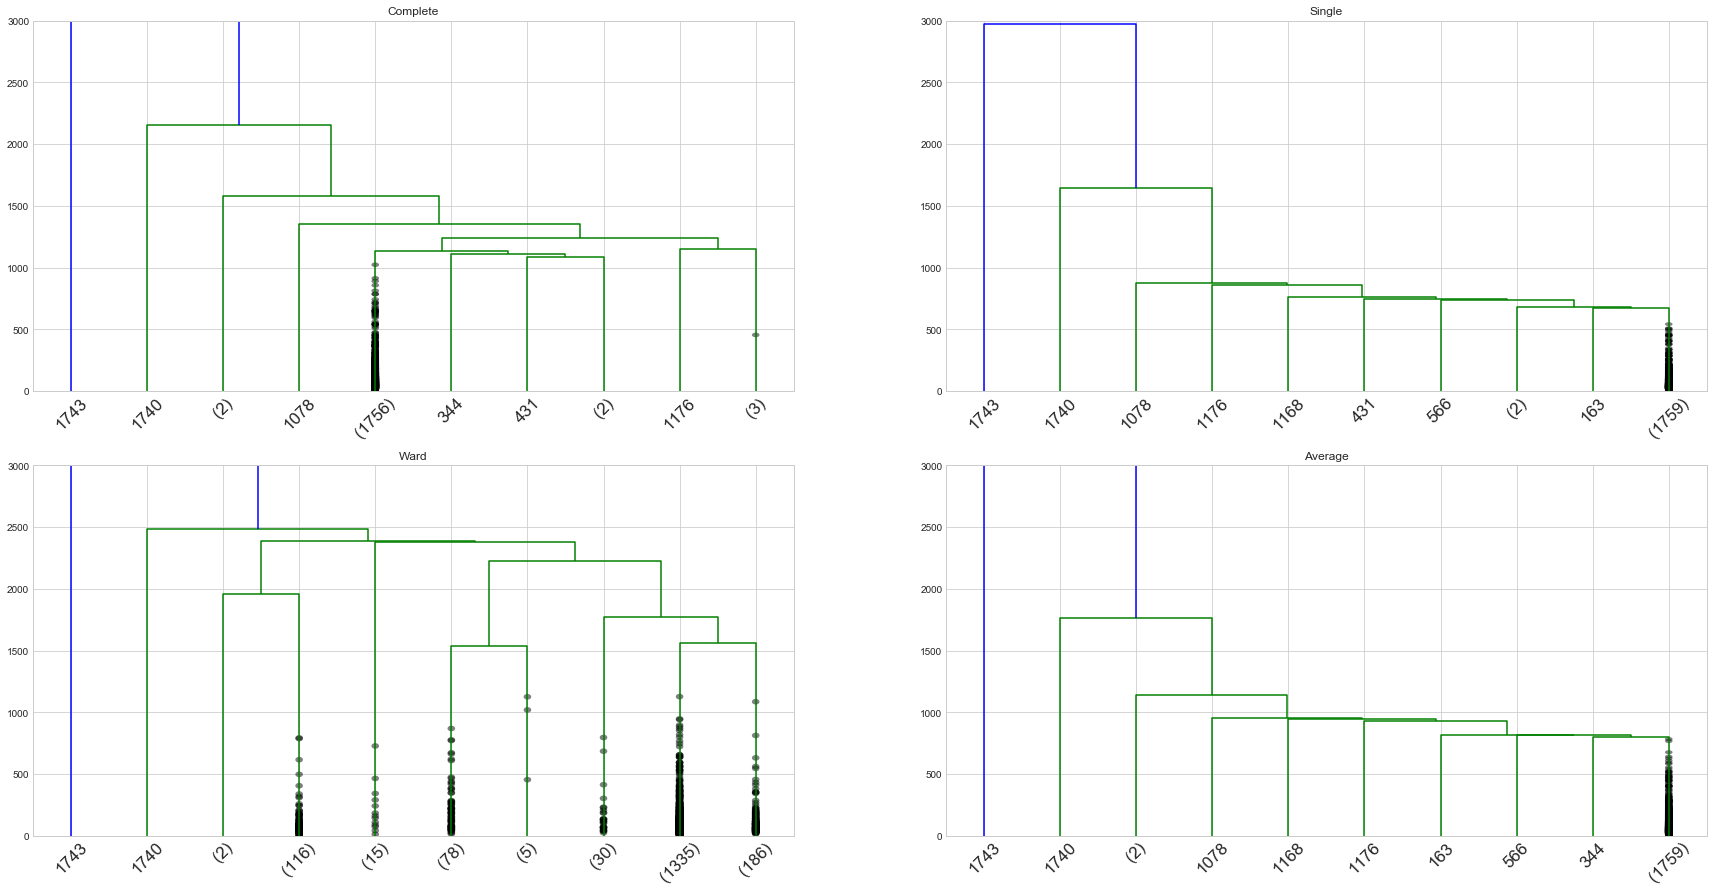

In [139]:
plt.figure(figsize=(30, 15))

plt.subplot(221)
dendrogram(Z_complete, truncate_mode='lastp', leaf_rotation=45., p=10, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 3000))
plt.title('Complete')

plt.subplot(222)
dendrogram(Z_single, truncate_mode='lastp', leaf_rotation=45., p=10, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 3000))
plt.title('Single')

plt.subplot(223)
dendrogram(Z_ward, truncate_mode='lastp', leaf_rotation=45., p=10, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 3000))
plt.title('Ward')

plt.subplot(224)
dendrogram(Z_average, truncate_mode='lastp', leaf_rotation=45., p=10, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 3000))
plt.title('Average')


plt.show()

In [142]:
edacopy[edacopy['13458'] > 300]

,minutes,14797,13412,14339,13418,13458,13580,13447,13485,13422,...,15000,16074,15102,16102,15011,14420,15255,15856,19542,15921
207,45,0.000,0.000,0.000,100.000,480.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
455,140,0.000,0.000,0.000,50.000,480.000,0.000,0.000,40.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
612,120,0.000,100.000,0.000,100.000,350.000,0.000,0.000,500.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
672,90,0.000,110.000,0.000,150.000,480.000,0.000,0.000,0.000,20.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
722,100,0.000,200.000,0.000,400.000,320.000,0.000,0.000,700.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1168,120,0.000,100.000,0.000,450.000,320.000,0.000,0.000,60.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1480,30,0.000,115.000,0.000,50.000,320.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1508,100,0.000,50.000,0.000,0.000,325.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1538,70,0.000,250.000,0.000,100.000,320.000,0.000,0.000,200.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1544,80,0.000,50.000,0.000,0.000,375.000,0.000,0.000,100.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [160]:
edacopy.to_csv('edacopy.csv')